In [156]:
import nltk
import re
import string
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
from collections import Counter
from gensim.utils import simple_preprocess
from gensim.models import word2vec
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.cluster import AffinityPropagation
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
np.seterr(divide='ignore', invalid='ignore')
pd.options.display.max_colwidth = 200

lemmatizer = WordNetLemmatizer()
stop=set(stopwords.words('english'))

In [157]:
data = pd.read_csv('./DS2_clean.csv', encoding='utf-8')
data.head()


,text,category,label
0,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...,normal,False
1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!,offensive_language,True
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit,offensive_language,True
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny,offensive_language,True
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;,offensive_language,True


In [158]:
data.describe()
data['label'] = data['label'].apply(lambda label: 0 if label == False else 1)

Percentage of Offensive language: 83.2%


Text(0.5, 1.0, 'Empirical distribution of the labels')

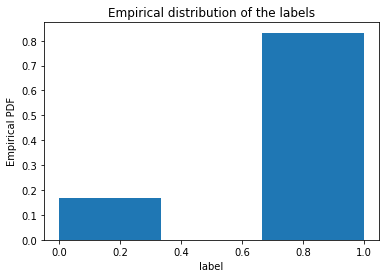

In [159]:
# Empirical distribution of the labels
print('Percentage of Offensive language: {0}%'.format(round(100 * data['label'].sum() / len(data['label']), 2)))
plt.hist(data['label'], bins=3, weights=np.ones(len(data['label'])) / len(data['label']))
plt.xlabel('label')
plt.ylabel('Empirical PDF')
plt.title('Empirical distribution of the labels')

In [160]:
data['text_length'] = data['text'].apply(lambda text: len(text))
data.sort_values(by='text_length', ascending=False)
# most of offensie are long sentences? 


,text,category,label,text_length
17865,RT @TrxllLegend: One good girl is worth a thousand bitches\n\n&#128112; = &#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128...,offensive_language,1,754
13402,No summer school? &#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#12851...,offensive_language,1,657
1596,&#8220;@Untouchable_T: Never seen so many perfect bitches til I made a Twitter &#128564; but &#128056;&#9749;&#65039;&#8221;&#128175;&#128175;&#128175;&#128175;&#128175;&#128175;&#128175;&#128175;...,offensive_language,1,637
16539,RT @Mr_MshkL: &#1589;&#1608;&#1585;&#1577; &#1604;&#1591;&#1575;&#1574;&#1585; &#1575;&#1604;&#1603;&#1575;&#1585;&#1583;&#1610;&#1606;&#1575;&#1604; &#1575;&#1604;&#1571;&#1581;&#1605;&#1585; &#1...,normal,0,522
18886,RT @digiflorals: bitch do it look like I care \n\n&#12288; N\n&#12288;&#12288; O\n&#12288;&#12288;&#12288; O\n&#12288;&#12288;&#12288;&#12288; o\n&#12288;&#12288;&#12288;&#12288;&#12288;o\n&#12288...,offensive_language,1,455
...,...,...,...,...
8944,Emd hoe,offensive_language,1,7
24619,u a hoe,offensive_language,1,7
24393,retard.,offensive_language,1,7
24364,pussy,offensive_language,1,5


Text(0.5, 1.0, 'Empirical distribution of the message lengths')

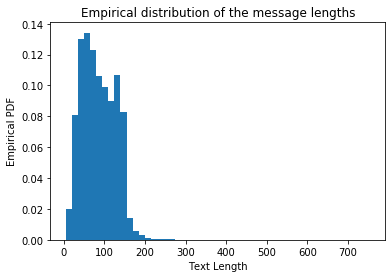

In [161]:
plt.hist(data['text_length'], bins=50, weights=np.ones(len(data))/len(data))
plt.xlabel('Text Length')
plt.ylabel('Empirical PDF')
plt.title('Empirical distribution of the message lengths')

In [163]:
def preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(lemmatizer.lemmatize(token, pos='v'))
    return " ".join(result).strip()

def clean_tweets(data):
    
    data["text"] = data['text'].apply(lambda x : x.lower())
    
    def html_decode(text):
        return BeautifulSoup(text, 'lxml').get_text().decode('utf-8')
    
    data['text'] = data['text'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())
    
    def remove_stopwords(text):
        if text is not None:
            return " ".join([x for x in word_tokenize(text) if x not in stop])
        else:
            return None
        
    def remove_URL(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'', text)
    
    def remove_mentions(text):
        mention = re.compile(r'(?:RT\s)@\S+', re.IGNORECASE)
        return mention.sub('', text)
    
    def remove_emoji(text):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    
    def remove_punct(text):
        table = str.maketrans('', '', string.punctuation)
        return text.translate(table)
    
    def remove_illegal(text):
        illegal = re.compile(r'”|“|’|\d+\S+')
        return illegal.sub('', text)
    
    func_list = [remove_URL, remove_mentions, remove_emoji, remove_punct, remove_stopwords, remove_illegal]
    
    for f in func_list:
        data['text'] = data['text'].apply(lambda x: f(x))
    
    # remove extra spaces left
    data.text = data.text.replace('\s+', ' ', regex=True)

clean_tweets(data)

In [164]:
data

,text,category,label,text_length
0,woman shouldnt complain cleaning house man always take trash,normal,0,140
1,boy dats coldtyga dwn bad cuffin dat hoe place,offensive_language,1,85
2,dawg ever fuck bitch start cry confused shit,offensive_language,1,120
3,vivabased look like tranny,offensive_language,1,62
4,shit hear might true might faker bitch told ya,offensive_language,1,137
...,...,...,...,...
24778,yous muthafin lie lifeasking coreyemanuel right tl trash … mine bible scriptures hymns,offensive_language,1,146
24779,youve gone broke wrong heart baby drove redneck crazy,normal,0,70
24780,young buck wan na eat dat nigguh like aint fuckin dis,offensive_language,1,67
24781,youu got wild bitches tellin lies,offensive_language,1,37


In [165]:
# extract spams and hams
offensive = data['text'].iloc[(data['label'] == 1).values]
normal = data['text'].iloc[(data['label'] == 0).values]
print(offensive[:10])
print(normal[:10])

1                         boy dats coldtyga dwn bad cuffin dat hoe place
2                           dawg ever fuck bitch start cry confused shit
3                                             vivabased look like tranny
4                         shit hear might true might faker bitch told ya
5      tmadisonx shit blows meclaim faithful somebody still fucking hoes
6                brighterdays sit hate another bitch got much shit going
7      selfiequeenbri cause im tired big bitches coming us skinny girls 
8                                          might get ya bitch back thats
9                        rhythmixx hobbies include fighting mariam bitch
10          keeks bitch curves everyone lol walked conversation like smh
Name: text, dtype: object
0                         woman shouldnt complain cleaning house man always take trash
40                                               momma said pussy cats inside doghouse
63                              addicted simplyaddictedtoguys woof woo

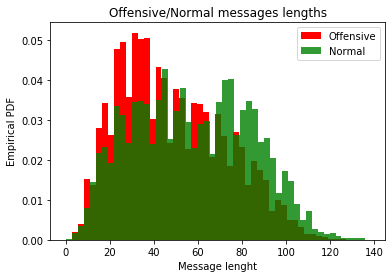

In [166]:
plt.hist(offensive.apply(lambda x: len(x)),
         bins=50,
         weights=np.ones(len(offensive)) / len(offensive),
         facecolor='r',
         label='Offensive')
plt.hist(normal.apply(lambda x: len(x)),
         bins=50,
         weights=np.ones(len(normal)) / len(normal),
         facecolor='g',
         alpha=0.8,
         label='Normal')
plt.xlabel('Message lenght')
plt.ylabel('Empirical PDF')
plt.title('Offensive/Normal messages lengths')

plt.legend()

In [167]:
# most common words in spam and ham
offensive_tokens = []
for word in offensive:
    offensive_tokens += nltk.tokenize.word_tokenize(word)
normal_tokens = []
for word in normal:
    normal_tokens += nltk.tokenize.word_tokenize(word)
print(offensive_tokens[:10])
print(normal_tokens[:10])


['boy', 'dats', 'coldtyga', 'dwn', 'bad', 'cuffin', 'dat', 'hoe', 'place', 'dawg']
['woman', 'shouldnt', 'complain', 'cleaning', 'house', 'man', 'always', 'take', 'trash', 'momma']


In [168]:
most_common_tokens_in_offensive = Counter(offensive_tokens).most_common(20)
most_common_tokens_in_normal = Counter(normal_tokens).most_common(20)
print(most_common_tokens_in_offensive)
print(most_common_tokens_in_normal)

[('bitch', 8247), ('bitches', 3087), ('like', 2467), ('hoes', 2362), ('pussy', 2111), ('hoe', 1881), ('im', 1853), ('dont', 1587), ('ass', 1571), ('got', 1467), ('fuck', 1415), ('get', 1286), ('shit', 1260), ('nigga', 1202), ('u', 1173), ('aint', 1119), ('lol', 939), ('niggas', 791), ('know', 718), ('fucking', 627)]
[('trash', 686), ('like', 301), ('bird', 293), ('charlie', 272), ('yankees', 264), ('im', 218), ('yellow', 214), ('dont', 169), ('birds', 167), ('lol', 144), ('get', 144), ('got', 131), ('one', 130), ('monkey', 111), ('ghetto', 110), ('u', 109), ('colored', 108), ('good', 94), ('know', 89), ('new', 88)]


In [169]:
data, test_data = train_test_split(data, test_size=0.3)
print('Train-valid data length: {0}'.format(len(data)))
print('Test data length: {0}'.format(len(test_data)))


Train-valid data length: 17348
Test data length: 7435


In [170]:
# build word2vec model
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in data['text']]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality
window_context = 10  # Context window size
min_word_count = 1   # Minimum word count
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

w2v = dict(zip(w2v_model.wv.index2word, w2v_model.wv.vectors))

In [171]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=7)]
                  for search_term in ['trash', 'niggers', 'bitch', 'taco', 'fuck','fugly']}
similar_words

{'trash': ['acct',
  'byes',
  'seton',
  'shutupandplay',
  'recycling',
  'hoppk',
  'rocked'],
 'niggers': ['alls',
  'brothas',
  'slightlyadjusted',
  'eyebrowsryanhslick',
  'activities',
  'jzsuschrist',
  'arounds'],
 'bitch': ['attitude',
  'mf',
  'somethin',
  'sneak',
  'nathanndevlin',
  'kiefferjason',
  'bf'],
 'taco': ['bell',
  'menstrual',
  'pads',
  'vin',
  'liesaboutvinscully',
  'jennifer',
  'hipotle'],
 'fuck': ['fucking', 'rather', 'sit', 'ass', 'loosing', 'swole', 'fleeto'],
 'fugly': ['handshakes',
  'kaylamauser',
  'nothingboo',
  'brotherbill7',
  'mykatmeows',
  'madness',
  'fuckherrightinthepussy']}

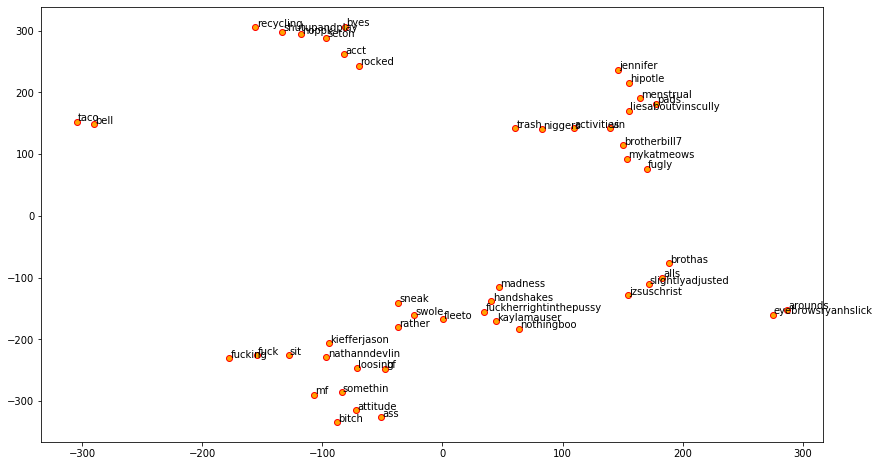

In [172]:
words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

(-0.5, 399.5, 199.5, -0.5)

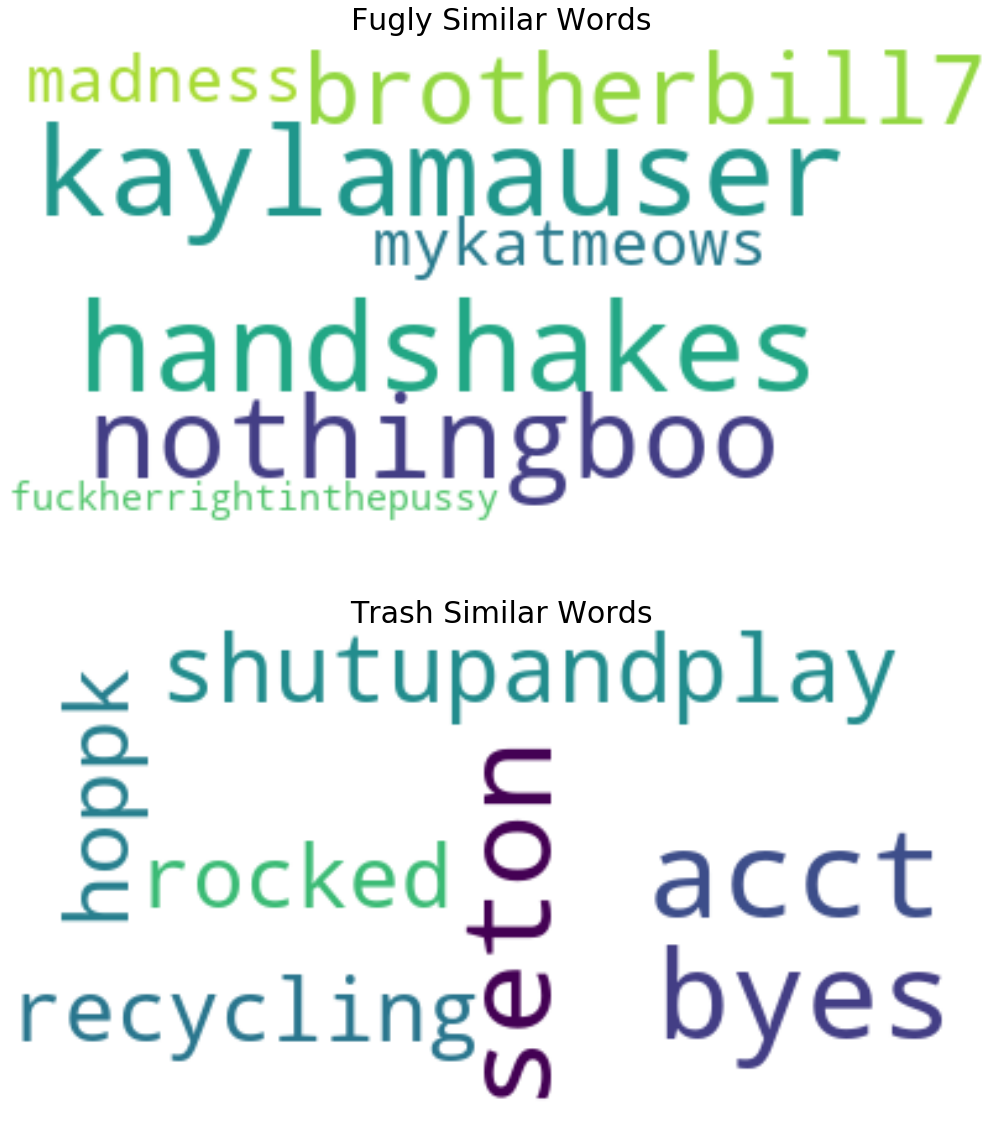

In [176]:
fig, ax = plt.subplots(2, 1, figsize  = (20,20))

# Create and generate a word cloud image:
wordcloud_fugly = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(similar_words['fugly']))
wordcloud_trash = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(similar_words['trash']))

# Display the generated image:
ax[0].imshow(wordcloud_fugly, interpolation='bilinear')
ax[0].set_title('Fugly Similar Words', fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_trash, interpolation='bilinear')
ax[1].set_title('Trash Similar Words',fontsize=30)
ax[1].axis('off')

In [55]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [17]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])


In [18]:
class Classifier(object):
    
    def __init__(self, model, param):
        self.model = model
        self.param = param
        self.gs = GridSearchCV(self.model, self.param, cv=5, error_score=0, refit=True)        

    def fit(self, X, y):        
        return self.gs.fit(X, y)

    def predict(self, X):
        return self.gs.predict(X)

In [19]:
clf_models = {
    'Naive Bayes': GaussianNB(), 
    'SVC': SVC(),
    'Decision Tree': DecisionTreeClassifier(),  
    'Perceptron': MLPClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Ada Boost': AdaBoostClassifier(),
    'MLP Classifier': MLPClassifier()
}

clf_params = {
    'Naive Bayes': { }, 
    'SVC': { 'kernel': ['linear', 'rbf'] },
    'Decision Tree': { 'min_samples_split': [2, 5] }, 
    'Perceptron': { 'activation': ['tanh', 'relu'] },
    'Gradient Boosting': { 'min_samples_split': [2, 5] },
    'MLP Classifier': { 'hidden_layer_sizes': [100,100]}
}

X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, shuffle=True)



In [ ]:
for key in clf_models.keys():
    
    clf = Pipeline([('Word2Vec vectorizer', MeanEmbeddingVectorizer(w2v)), ('Classifier', Classifier(clf_models[key], clf_params[key]))])
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(key, ':')
    print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')))